<img src="http://www.iconarchive.com/download/i60730/double-j-design/origami-colored-pencil/yellow-home.ico" style="float: left; margin: 0px 25px 0px 0px; height: 100px">



 #  Project 1: Regression and classification with housing data

This project aims to provide a reliable estimator of property price for residential properties in Ames, Iowa. It will then evaluate the additional value that can be brought about through property improvements, providing a framework for  renovation investment decisions.

* Initially I will focus on understanding the provided data set and cleaning the data; dealing with missing data and also removing any outliers that may reduce the effectiveness of the model. 

* In the first section of this project I will build a linear regression model that will esitmate the value of a property based on it's fixed features

* The second part of this project will estimate the mean dollar value of different renovations, this will help to identify which property renovations will yield the greatest return in order to maximise profits.

* Finally I will look at what features of a property sale can effectively predict an abormal sale, such as a foreclosure or short sale, using a logistic regression model.  


In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics, datasets
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
house = pd.read_csv('./housing.csv')

<img src="http://www.bolero.fr/wp-content/uploads/2015/04/loupe.png" style="float: left; margin: 10px 25px 0px 0px; height: 60px">

### 0.1 Exploring and understanding the data through visualisation

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can see from the above data that we have 79 features plus sales price, which we are trying to predict. There are a lot of features here which may cause some issues when building a model due to colinearity between features (i.e. 1stFlrSF and GrLivArea are likely to be highly related) additionally the large number of features can make the model much harder for the client to interpret.

We can also see that we will need to do quite a bit of data cleaning as there are a lot of missing values. 

But first, lets look at the target variable, Sales Price and understand a little more about the distributuion. 

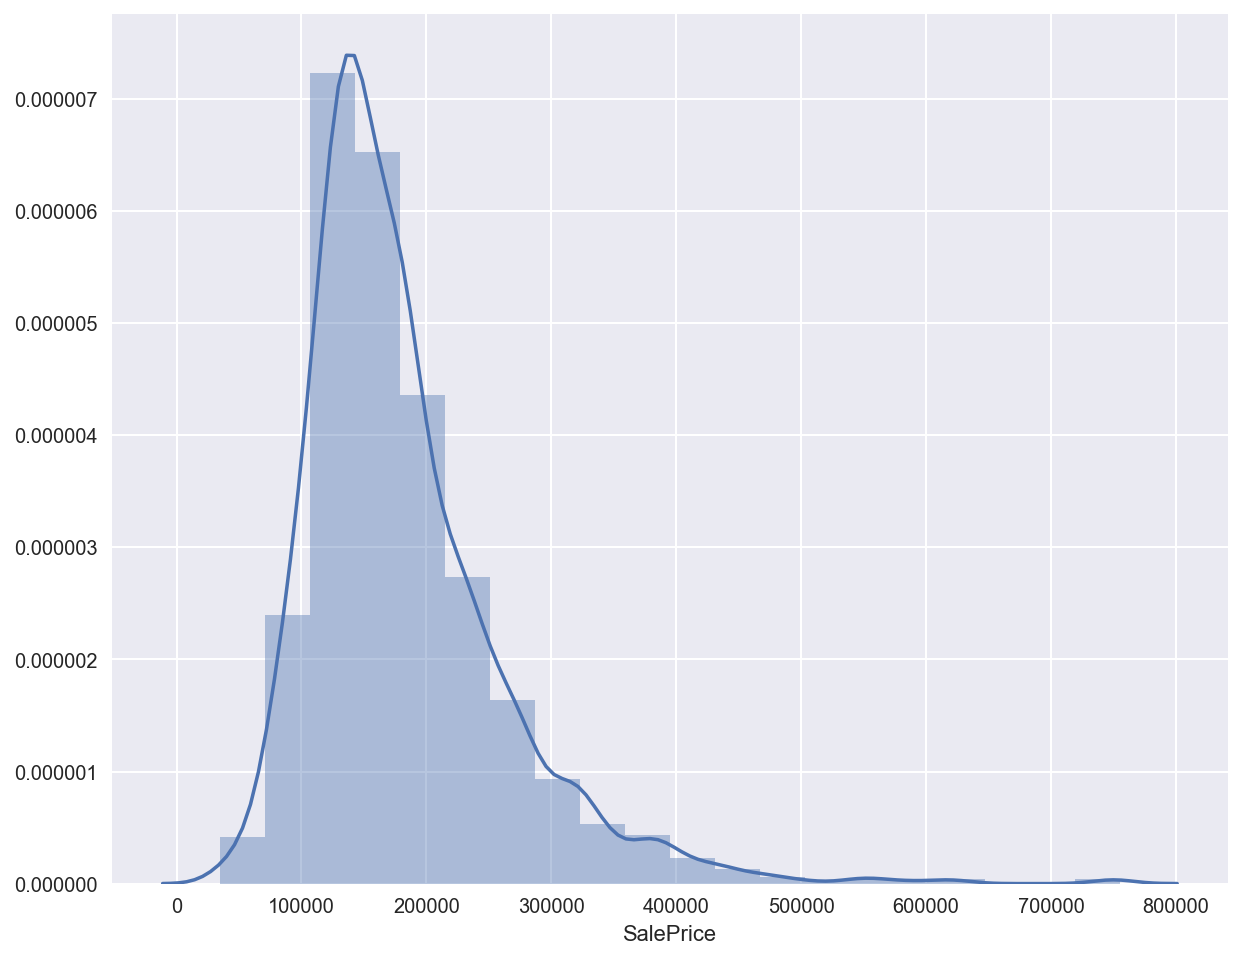

In [4]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
sns.distplot(house.SalePrice, kde=True, ax=ax, bins=20)
plt.show()

from the graph above we can see that Sales Price is not normally distributed, in fact it is very possitively skewed which is what we would expect for house prices. Due to this skew we could transform the data logarithmically however I will want to be able to interpret the results later on so I'm going to leave the target as it is and see how the model performs. 


#### Correlation between features

In [5]:
#before I continue I am going to remove all commercial properties from the dataset
house = house[house.MSZoning != 'C (all)']

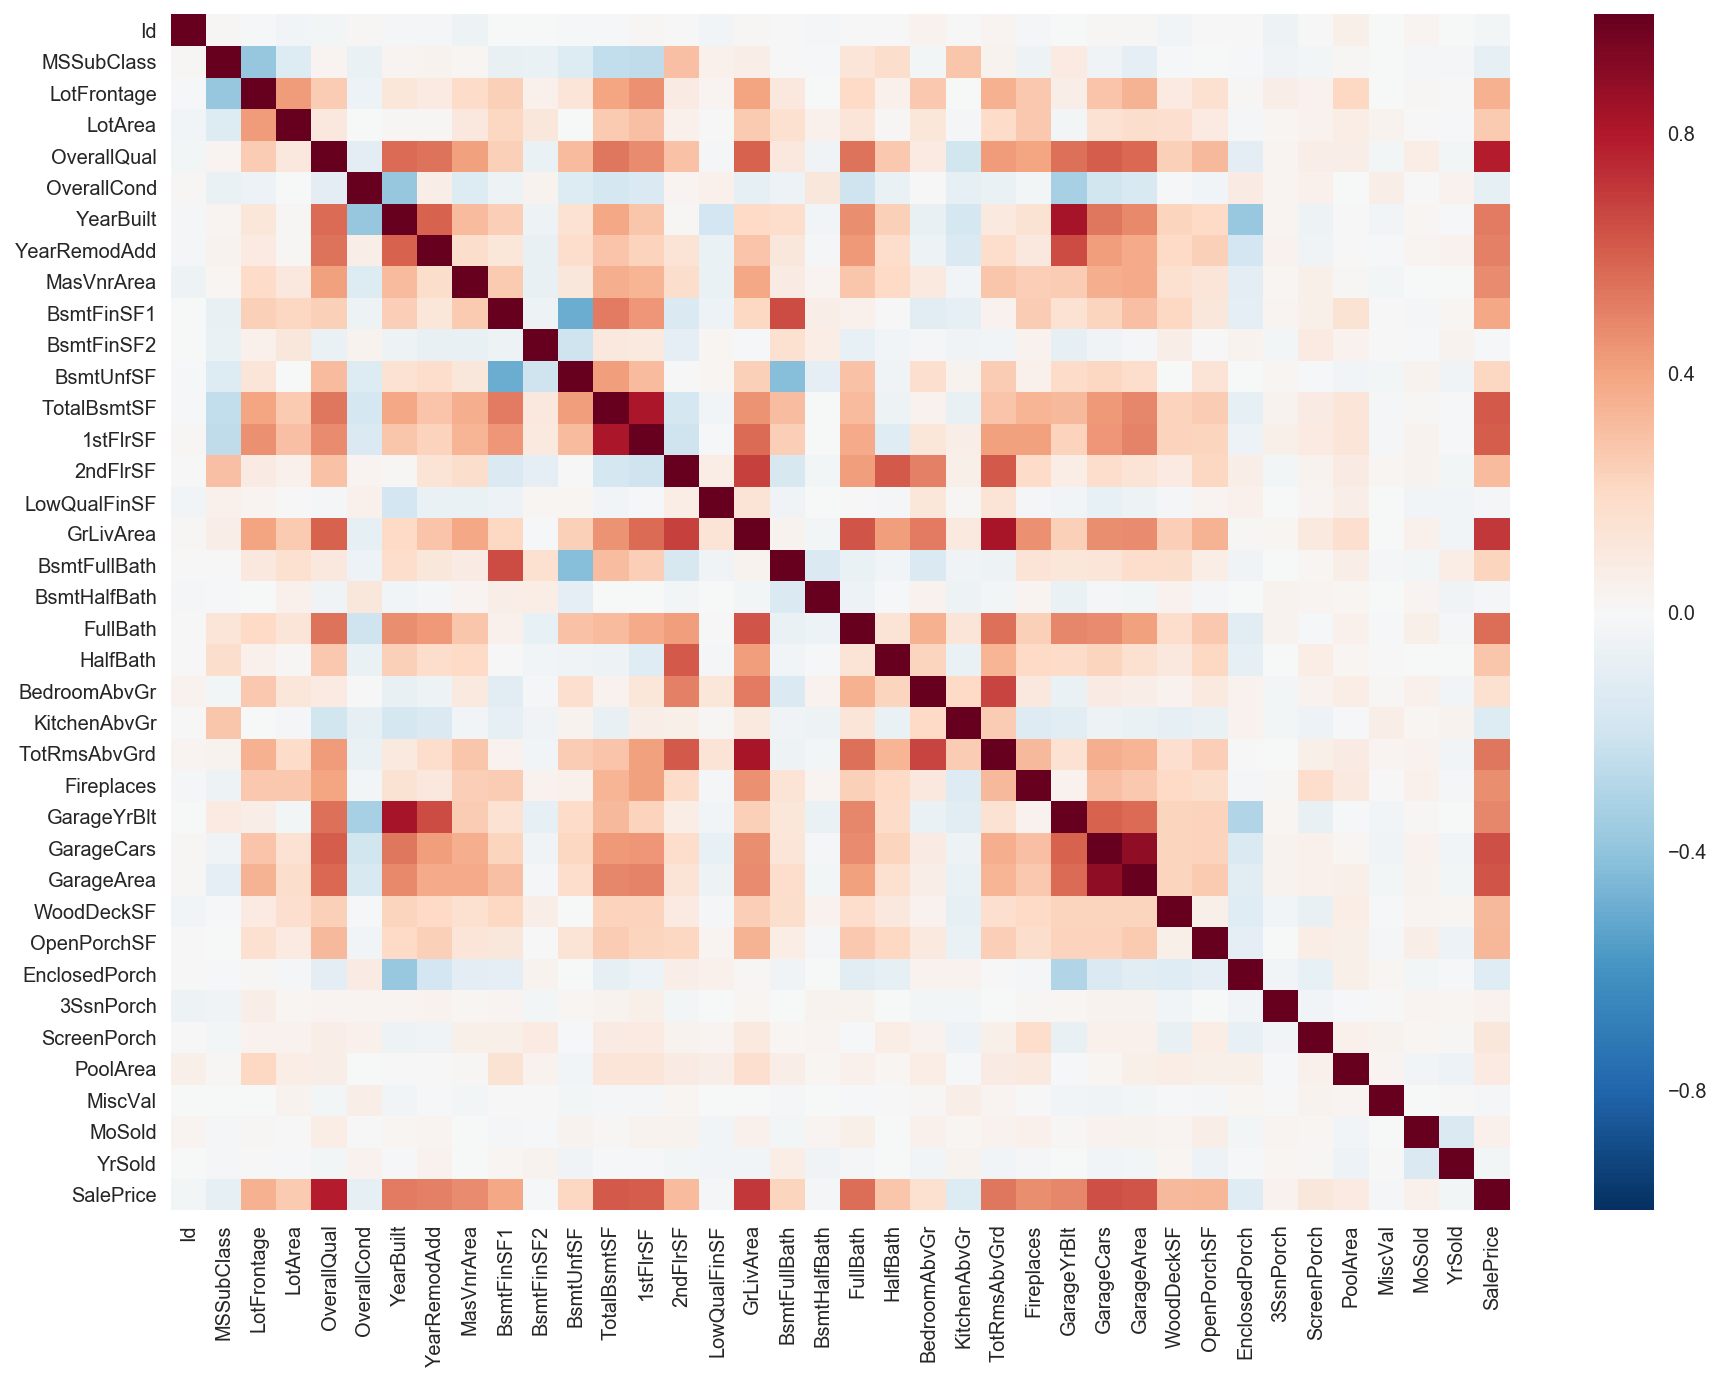

In [6]:
fig = plt.figure(figsize = (15,11))
ax = fig.gca()
sns.heatmap(house.corr())
plt.show()

I've created a heatmap to better understand the relationships between the numerical features in the data set. As predicted there's high colinearity between some features, it's particularly high between the different garage variables and also the different square footage variables.

We can see there are several features that are highly correlated with Sales Price, I'd like to take a look at these in a little more detail. 

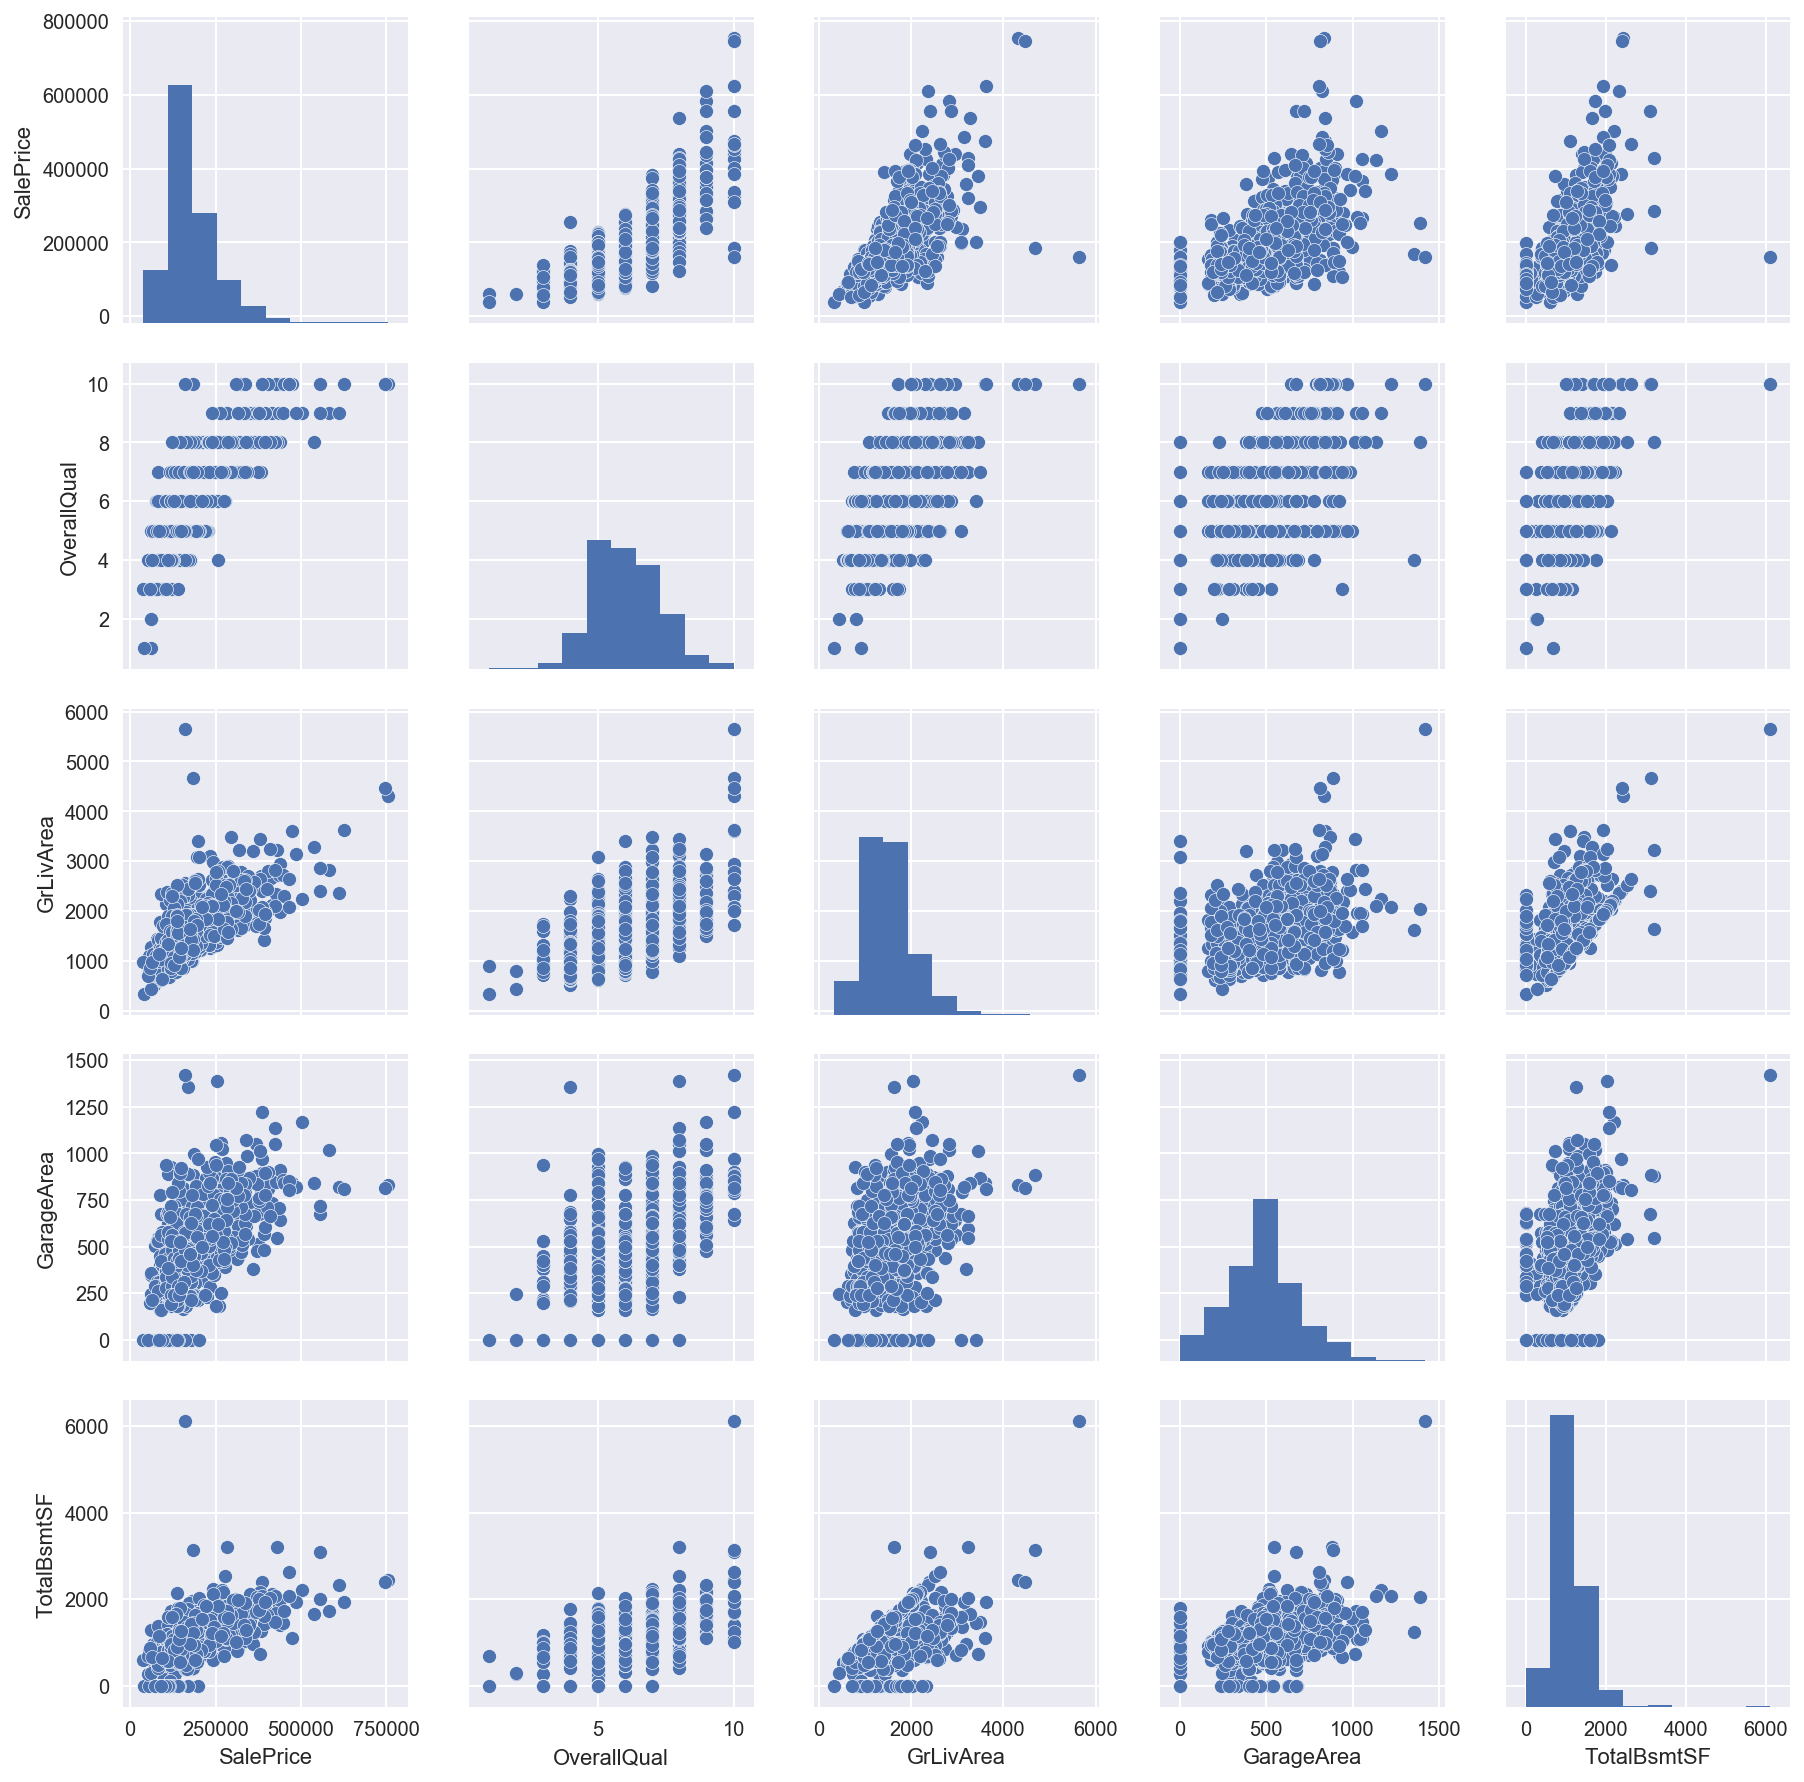

In [7]:
sns.pairplot(house[['SalePrice','OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']])
plt.show()

We can see there's an outlier here for Total Basement SF, i'm just going to drop this observation. 

In [8]:
house.TotalBsmtSF.max()

6110

In [9]:
house = house[house.TotalBsmtSF != 6110]

There are also some outliers in the above grade living area relationship with sales price, I am also going to remove these, as there is a high change they will reduce the accuracy of my model. 

In [10]:
house = house[house.GrLivArea < 4000]

#### Categorical variables and their relationship with price


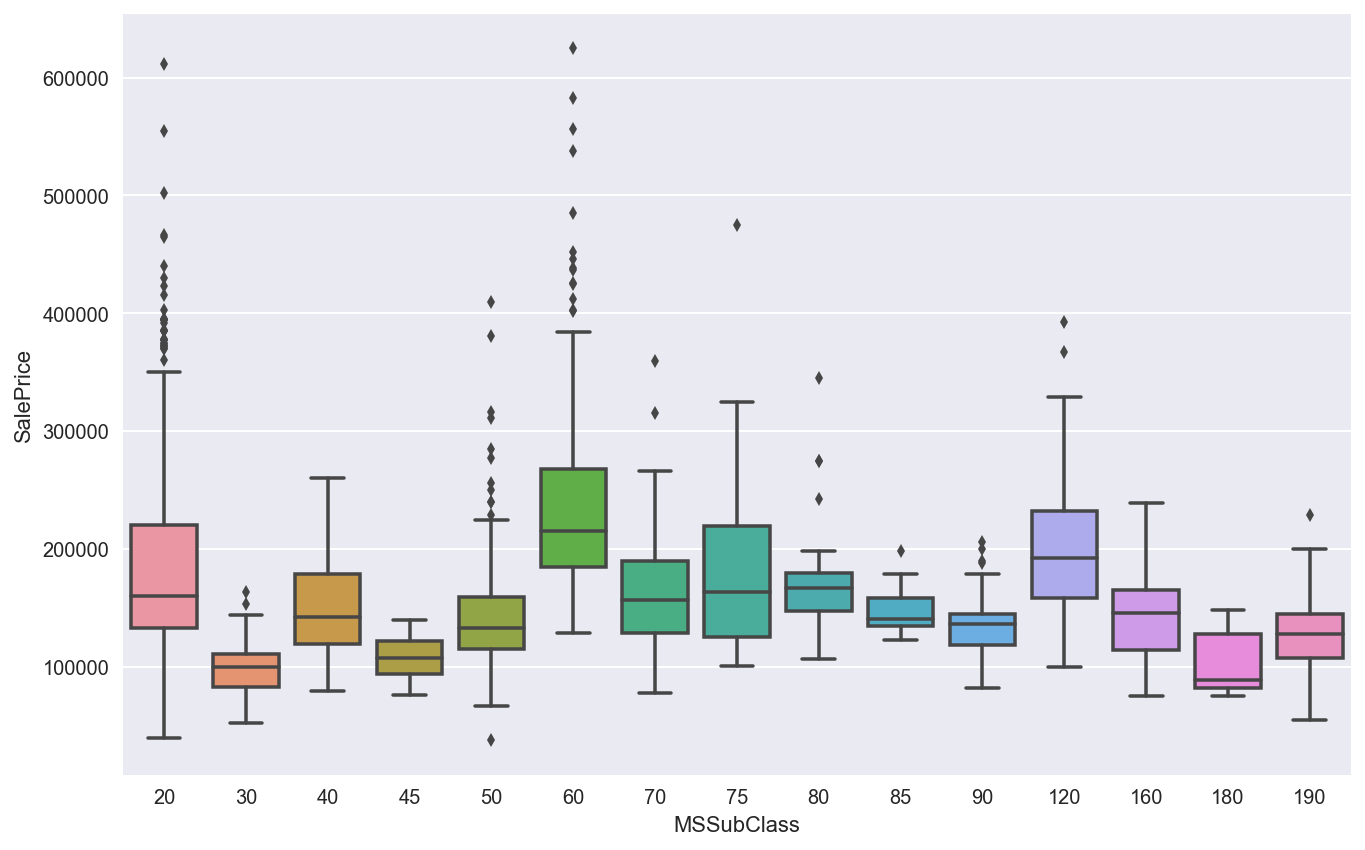

In [11]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()
sns.boxplot('MSSubClass', 'SalePrice', data=house)
plt.show()

In the above graph we can see that newer properties tend to have a higer sales price than the equivalent property that is older. We can see the significant price differences between MSSubClass 20 (newer 1-story) and 30 (older 1-story) as well as between MSSubClass 60 (newer 2-story) and 70 (older 2-story). 

We can also see that unfinished properties have a lower sales price than their finished equivalent (MSSubClass 45: unfinished and 50: finished). 
                    
                 MSSubClass categories
                 
                 20: '1-STORY 1946 & NEWER ALL STYLES',
                 30: '1-STORY 1945 & OLDER',
                 40: '1-STORY W/FINISHED ATTIC ALL AGES',
                 45: '1-1/2 STORY - UNFINISHED ALL AGES',
                 50: '1-1/2 STORY FINISHED ALL AGES',
                 60: '2-STORY 1946 & NEWER',
                 70: '2-STORY 1945 & OLDER',
                 75: '2-1/2 STORY ALL AGES',
                 80: 'SPLIT OR MULTI-LEVEL',
                 85: 'SPLIT FOYER',
                 90: 'DUPLEX - ALL STYLES AND AGES',
                120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                150: '1-1/2 STORY PUD - ALL AGES',
                160: '2-STORY PUD - 1946 & NEWER',
                180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                190: '2 FAMILY CONVERSION - ALL STYLES AND AGES

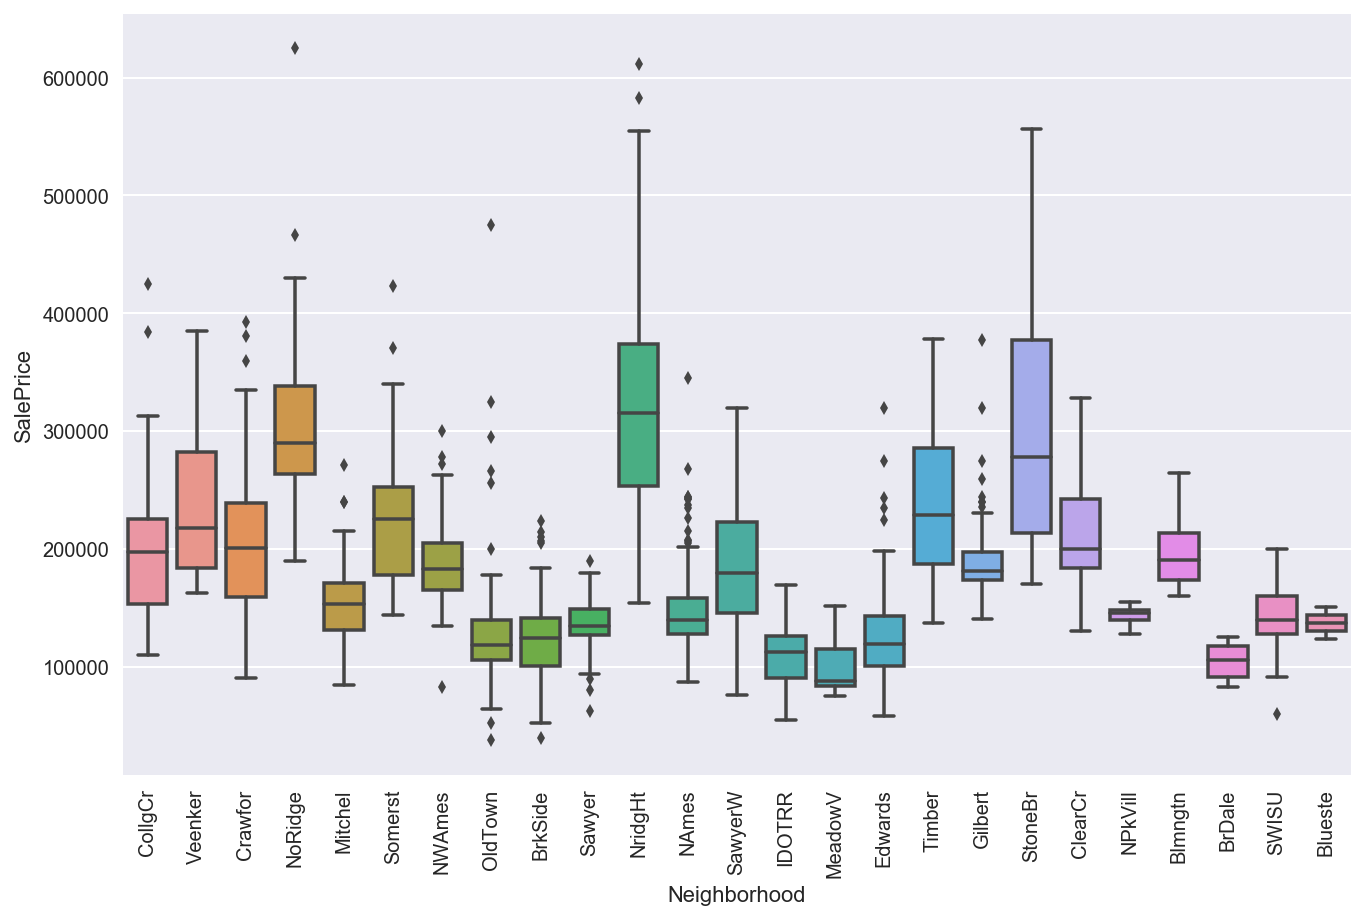

In [12]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()
sns.boxplot('Neighborhood', 'SalePrice', data=house)
plt.xticks(rotation=90)
plt.show()

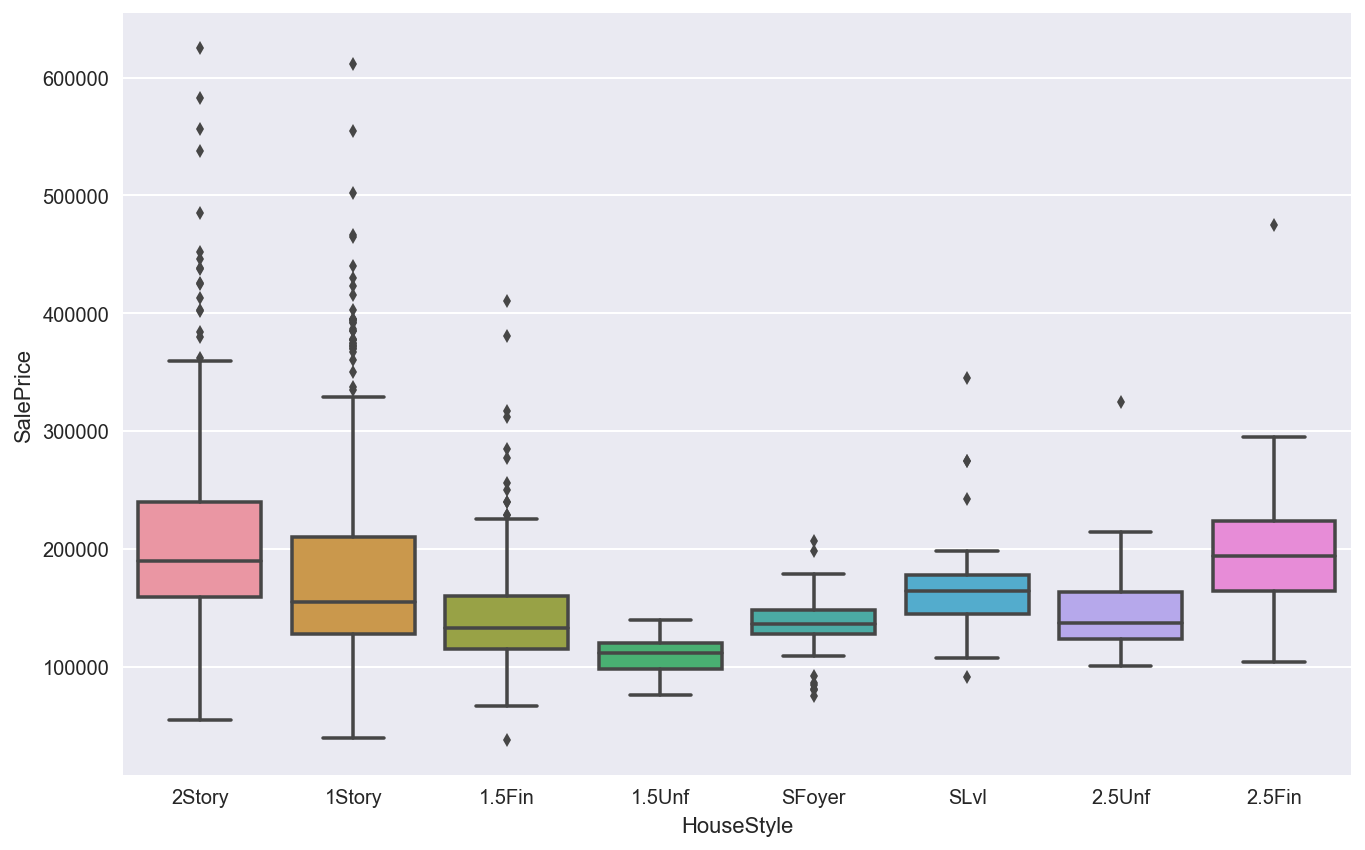

In [13]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()
sns.boxplot('HouseStyle', 'SalePrice', data=house)
plt.show()

Here we can see a similar relationship to above, equivalent properties are worth more if they are finished than unfinished and price generally is higher if the propertu is spread over more floors.
   
       HouseStyle: Style of dwelling
            
           2Story	Two story
           1Story	One story
           1.5Fin	One and one-half story: 2nd level finished
           1.5Unf	One and one-half story: 2nd level unfinished
           2.5Fin	Two and one-half story: 2nd level finished
           2.5Unf	Two and one-half story: 2nd level unfinished
           SFoyer	Split Foyer
           SLvl	    Split Level

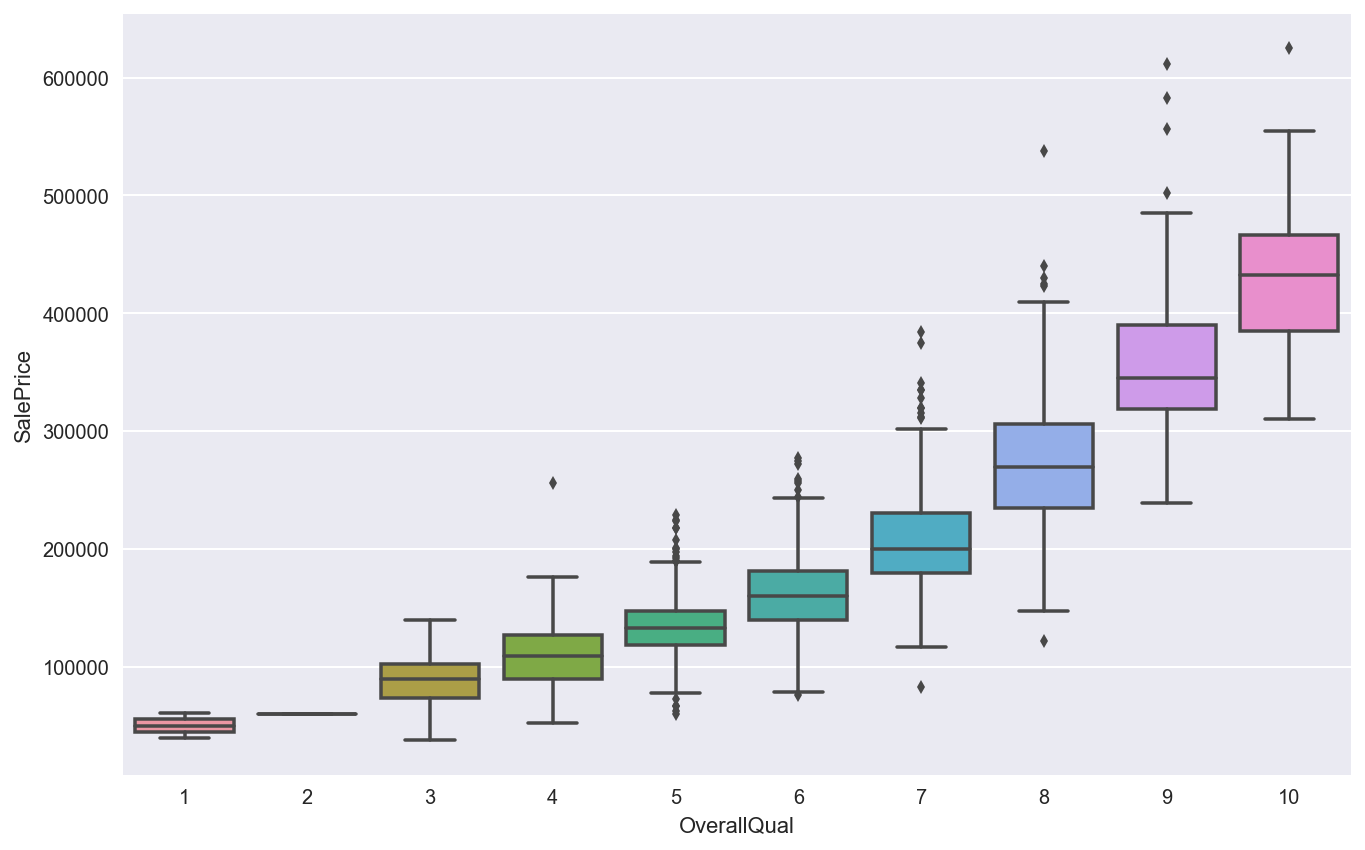

In [14]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()
sns.boxplot('OverallQual', 'SalePrice', data=house)
plt.show()

Here we can see a really clear increase in sales price with the overall quality of the property. 

<img src="https://www.iconexperience.com/_img/g_collection_png/standard/512x512/broom.png" style="float: left; margin: 10px 25px 0px 0px; height: 50px">
 

### 0.2 Data cleaning



In [15]:
house.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1441
MiscFeature     1394
Alley           1357
Fence           1169
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

It looks like the data is missing a lot of values here, however upon closer inspection of the data and the descritpion file it is clear many of these are not missing values, they just do not have the feature that is being reported. 

Variables where there is actually missing data: 
 
* lot frontage has 259 missing values 
* MasVnrType + MasVnrArea have 8 missing values.
* Electircal has one missing value 


The follwoing variables do not have missing data they are just missing that feature so we will change the null value to na:

* 1442 properties do not have a pool
* 1397 properties do not have miscellaneous features
* 1360 properties do not have alley access
* 1171 properties do not have a fence
* 680 properties do not hace a fireplace
* 78 properties do not have a garage 
* 37 properties do not have a basement


In [16]:
# check utilities for the property with the missing value for electrical
house.Utilities[house.Electrical.isnull()]

1379    AllPub
Name: Utilities, dtype: object

As we can see from the above the property actually has all public utilities; including Electricity, Water, Gas and Sewage. Therefore we will change the electricity type to the most common in the data set. 

In [17]:
house.Electrical.value_counts()

SBrkr    1324
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [18]:
electicity_mask = house.Electrical.isnull()
house.loc[electicity_mask, 'Electrical'] = 'SBrKr'

In [19]:
house.MasVnrType.value_counts()

None       853
BrkFace    444
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

In [20]:
(house.MasVnrArea == 0).value_counts()

True     850
False    596
Name: MasVnrArea, dtype: int64

From the above it would make sense that the eight properties that have missing values for masonary vaneer type do not have a masonary vaneer, as such I will change the type to 'none' and the area to 0. 

In [21]:
MasVnr_mask = house.MasVnrArea.isnull()
house.loc[MasVnr_mask, 'MasVnrArea'] = 0 
MasVnr_mask2 = house.MasVnrType.isnull()
house.loc[MasVnr_mask2, 'MasVnrType'] = 'None'

For the missing values on lot frontage I have a few options, firstly it may be that some properties don't have a frontage, this could be flats set back from the road, however upon inspection of the property type this isn't the case. As such I will either impute the missing values with the mean or the median value.

In [22]:
house.LotFrontage.describe()

count    1187.000000
mean       69.693345
std        23.061037
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

The mean and median values are really close so it won't make much difference which I choose here. 

In [23]:
lot_frontage_mask = house.LotFrontage.isnull()

house.loc[lot_frontage_mask, 'LotFrontage'] = 70

For the missing values for the year the garage is built I am going to impute the year that the property was built. 

In [24]:
house.loc[house.GarageYrBlt.isnull(), 'GarageYrBlt'] = house.loc[house.GarageYrBlt.isnull(), 'YearBuilt']

In [25]:
null_to_na = ['MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageType','GarageFinish','GarageQual',
              'BsmtExposure', 'BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual','PoolQC']

for col in null_to_na:
    mask = house[col].isnull()
    house.loc[mask, col] = 'NA'

In [26]:
house.isnull().sum().sort_values(ascending=False).head(2)

SalePrice    0
Heating      0
dtype: int64

Great, no more missing values. 

In [27]:
# chnage MSSubClass to string as it is a categorical variable
house['MSSubClass'] = house['MSSubClass'].astype(str)

<img src="http://www.effilux.fr/img/societe/icons/icon-n1.png" style="float: left; margin: 25px 25px 0px 0px; height: 60px">



## Part 1:
** Estimating the value of homes from fixed characteristics **

### 1.1 Preparing data for linear regression

Initially I will create the lists of the fixed characteristics and the characteristics that can easily be renovated upon. 

I have separated out sale month and year sold from the data as I don't feel that these fall into either category.

In [28]:
fixed_feat_list = ['MSSubClass', 'MSZoning', u'LotFrontage', u'LotArea', u'Street', u'Alley', u'LotShape', 
                        u'LandContour',  u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
                        u'Condition2', u'BldgType', u'HouseStyle',u'YearBuilt', u'YearRemodAdd',u'MasVnrArea', 
                        u'Foundation', u'BsmtExposure', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'GrLivArea', 
                        u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr',
                        u'TotRmsAbvGrd', u'Fireplaces', u'GarageType', u'GarageCars', u'GarageArea', u'SaleType', u'SaleCondition'
                        ]

In [29]:
renovate_feat_list = ['Utilities', u'OverallQual', u'OverallCond', u'RoofStyle', u'RoofMatl', u'Exterior1st', 
                         u'Exterior2nd', u'MasVnrType', u'ExterQual', u'ExterCond', u'BsmtQual', u'BsmtCond', 
                         u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', 
                         u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'LowQualFinSF', u'KitchenQual', 
                         u'Functional', u'FireplaceQu', u'GarageFinish', u'GarageQual', u'GarageCond', u'PavedDrive', 
                         u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', 
                         u'PoolQC', u'Fence', u'MiscFeature', u'MiscVal']

In [30]:
sale_info = [ u'MoSold', u'YrSold']

In [31]:
def create_df_dummies (feat_list, df):

    feat_df = df[feat_list]
    feat_num = (feat_df.describe().columns.tolist()) 
    feat_categ = [col for col in feat_df.columns if col not in feat_num]
    feat_df = pd.get_dummies(feat_df, columns=feat_categ, drop_first=False)
    feat_df['YrSold'] = house.YrSold
    return feat_df    

In [32]:
fixed_feat = create_df_dummies(fixed_feat_list, house)

In [33]:
X_train = fixed_feat[fixed_feat.YrSold != 2010]
X_test = fixed_feat[fixed_feat.YrSold == 2010]
y_train = house.SalePrice[house.YrSold != 2010]
y_test = house.SalePrice[house.YrSold == 2010]

### 1.2 Fitting a linear regression model

I will need to standardise my numerical features before fitting a regression model on the data. If I don't do this it will over represent some features due to the differences in the scales of the data. I am just going to use a standard scaling method that transform the mean of the variables to 0 and the standard deviation to 1. 

In [34]:
scaler = StandardScaler()
feat_standardise = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                    'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                    'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','YrSold']
X_train[feat_standardise] = scaler.fit_transform(X_train[feat_standardise])
X_test[feat_standardise] = scaler.transform(X_test[feat_standardise])

X_train_s = X_train
X_test_s = X_test

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [35]:
lm = LinearRegression()
model = lm.fit(X_train_s, y_train)
y_pred = model.predict(X_train_s)
score = metrics.r2_score(y_train, y_pred)
print 'r^2 score: ', score 

r^2 score:  0.896081368223


In [36]:
mean_error = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
print 'Mean error: ', mean_error

Mean error:  24472.2960963


In [96]:
y_pred_cv = cross_val_predict(model, X_train_s, y_train, cv=5)
score_cv = cross_val_score(model, X_train_s, y_train, cv=5)
print 'Cross validated r^2 scores: ', score_cv
print 'Mean cross validated r^2 score: ', score_cv.mean()

Cross validated r^2 scores:  [  8.51639341e-01  -1.93401733e+17  -1.62026854e+19  -2.43210097e+17
  -8.49377558e+17]
Mean cross validated r^2 score:  -3.49773495135e+18


After cross validation our model performed quite poorly, it is likely that this is due to the high number of dummy variables that we have. It means that during the cross validations the model may not have encountered one or more of the variables in the training set, therfore it performs poorly when it encounters it in the test set. 

As mentioned above, we know that we have high collinearity between features so next I am going to use two different regularisation methods (Ridge and Lasso) to penalise variables with high collinearity by reducing their coefficients. 

### 1.3 Regularisation 

##### Ridge

I'll use gridsearch to find the best alpha using ridge regression first

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [39]:
params = {'alpha':np.logspace(0, 2, 200)}
rr = Ridge()
estimator = GridSearchCV(rr, params, cv=3)
estimator.fit(X_train_s, y_train)
estimator.best_estimator_

Ridge(alpha=7.4881038575900227, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [40]:
best_r = estimator.best_estimator_.fit(X_train_s, y_train)
y_pred_ridge = best_r.predict(X_train_s)
print 'Model alpha: ', np.round(best_r.alpha, 4)
print 'Ridge r^2 score: ', np.round(r2_score(y_train, y_pred_ridge), 6)
print 'Ridge mean error: ', np.round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_ridge)), 4)

Model alpha:  7.4881
Ridge r^2 score:  0.891963
Ridge mean error:  24952.5219


In [41]:
def plot_hp_alpha_opt(rep, kind = 'Ridge'):
    x= rep['param_alpha']
    y= rep['mean_test_score']


    plt.figure(figsize=(15,3))
    plt.plot(x,y,label = '{} with Mixed Scaling (mean test score)'.format(kind))
    plt.xscale('log')
    plt.ylabel('R2 score \n' ,size=18)
    plt.yticks(size = 15)
    plt.xlabel('alpha',size =18)
    plt.title('Model Hyperparameter Optimisation \n',size=20)
    plt.legend(fontsize=14)

    plt.show()

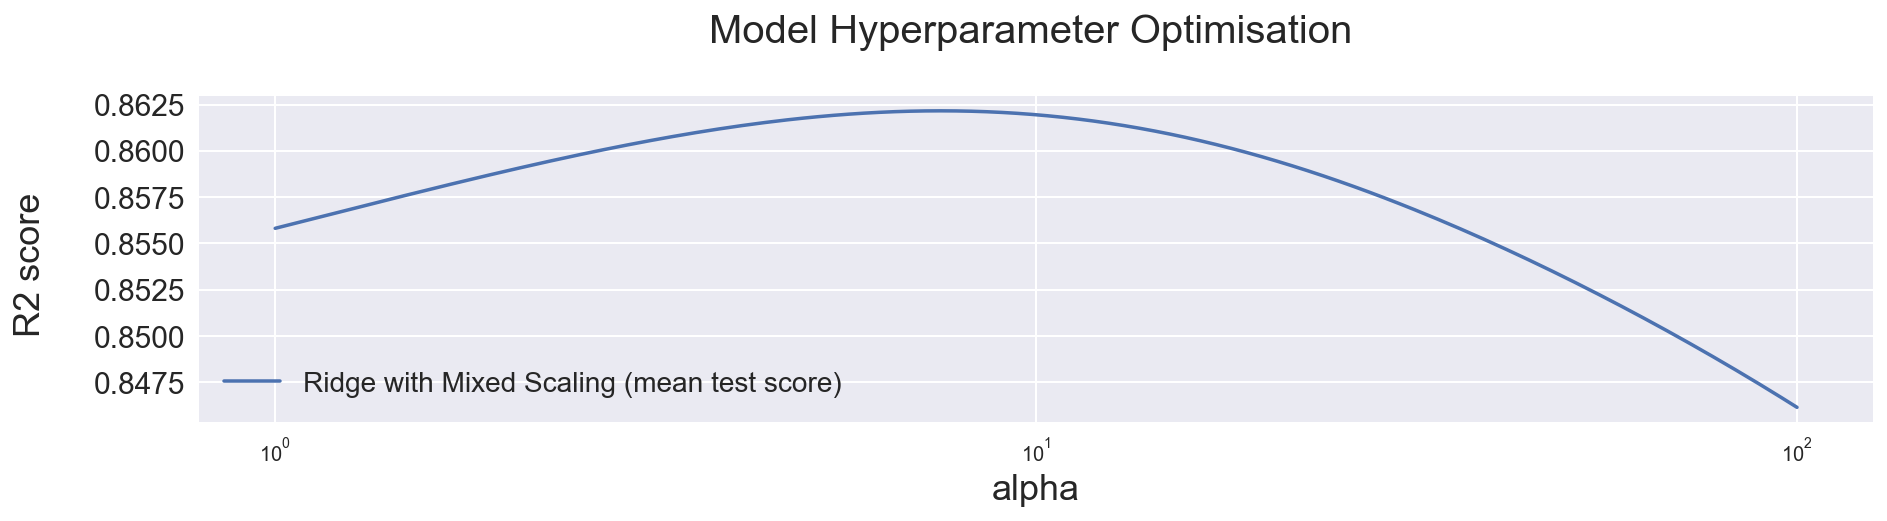

In [42]:
ridge_fm_report = pd.DataFrame(estimator.cv_results_)
plot_hp_alpha_opt(ridge_fm_report)

I can see from the above that the optimal alpha for ridge regression is around 7, which has resulted in a r^2 score of 0.891963. 

##### Lasso

I'll now use gridsearch on Lasso to find the best hyperparameters 

In [43]:
params_l = {'alpha':np.logspace(1, 2, 200)}
lr = Lasso()
estimator_l = GridSearchCV(lr, params_l, cv=3)
estimator_l.fit(X_train_s, y_train)
estimator_l.best_estimator_

/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=81.19844993184013, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [44]:
best_l = estimator_l.best_estimator_.fit(X_train_s, y_train)
y_pred_lasso = best_l.predict(X_train_s)
print 'Model alpha: ', np.round(best_l.alpha, 4)
print 'Ridge r^2 score: ', np.round(r2_score(y_train, y_pred_lasso), 6)
print 'Ridge mean error: ', np.round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_lasso)), 4)

Model alpha:  81.1984
Ridge r^2 score:  0.889558
Ridge mean error:  25228.6677


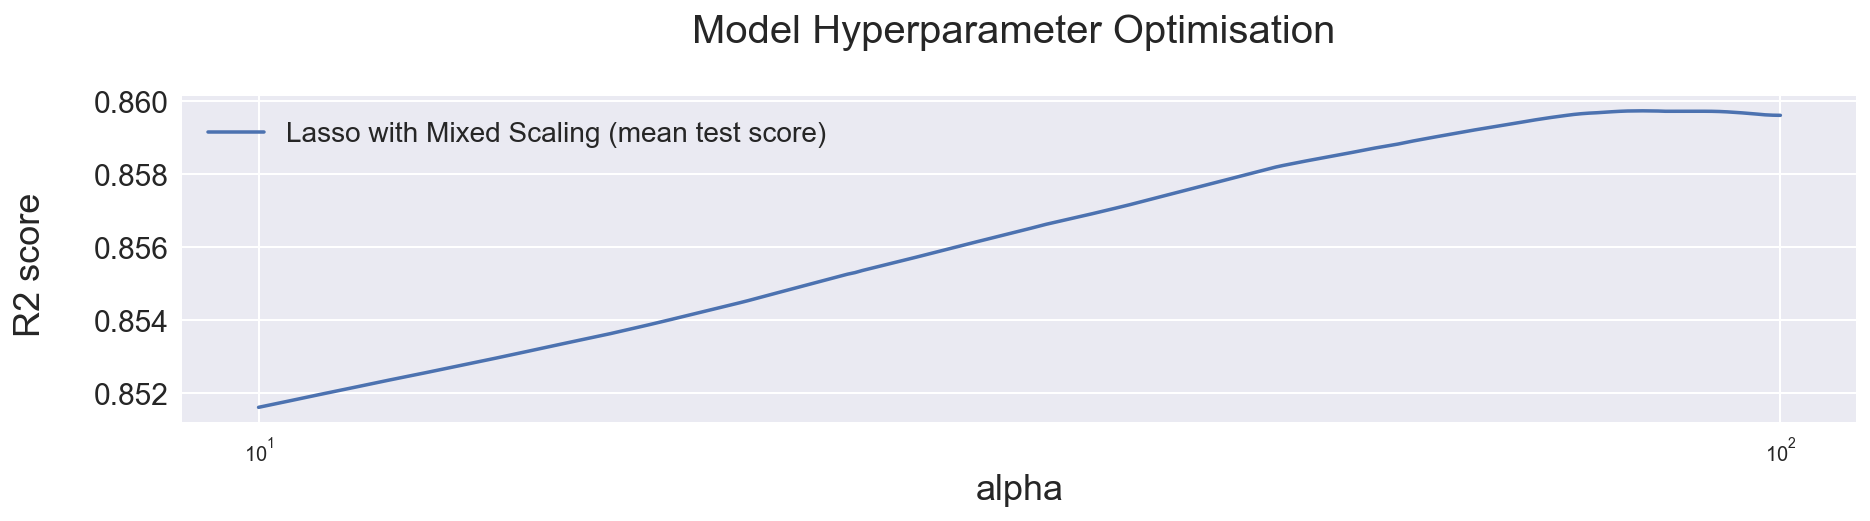

In [45]:
las_fm_report = pd.DataFrame(estimator_l.cv_results_)
plot_hp_alpha_opt(las_fm_report, kind='Lasso')

##### Checking against test data 

The r^2 score was slightly higher using Ridge than Lasso, therefore this is the model that i'll choose to use on the test data.

In [46]:
y_pred_ridge_test = best_r.predict(X_test_s)
print 'Ridge r^2 score: ', np.round(r2_score(y_test, y_pred_ridge_test), 6)
print 'Ridge mean error: ', np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_test)), 4)

Ridge r^2 score:  0.883112
Ridge mean error:  27259.9782


The model also performed well on the test data. 

<img src="http://sigmatechnology.se/wp-content/uploads/sites/2/2015/04/icon-step-2.png" style="float: left; margin: 20px 25px 0px 0px; height: 60px">

## Part 2:

** Determine any value of changeable property characteristics unexplained by the fixed ones **

I am now going to use my chosen model from part 1 on my whole data set to find the residuals of the model. I will then try to find out how much of the residuals can be explained by the renovateable property attributes. 

In [47]:
Xd = create_df_dummies(fixed_feat_list, house)
y = house.SalePrice

In [48]:
scaler = StandardScaler()
Xd[feat_standardise] = scaler.fit_transform(Xd[feat_standardise])
X= Xd

In [49]:
y_pred_whole = best_r.predict(X)
print 'Ridge r^2 score: ', r2_score(y, y_pred_whole)
print 'Ridge mean error: ', np.sqrt(metrics.mean_squared_error(y, y_pred_whole))

Ridge r^2 score:  0.890852807344
Ridge mean error:  25234.6008208


### 2.1 Finding the residuals

In [50]:
y_res = y - y_pred_whole

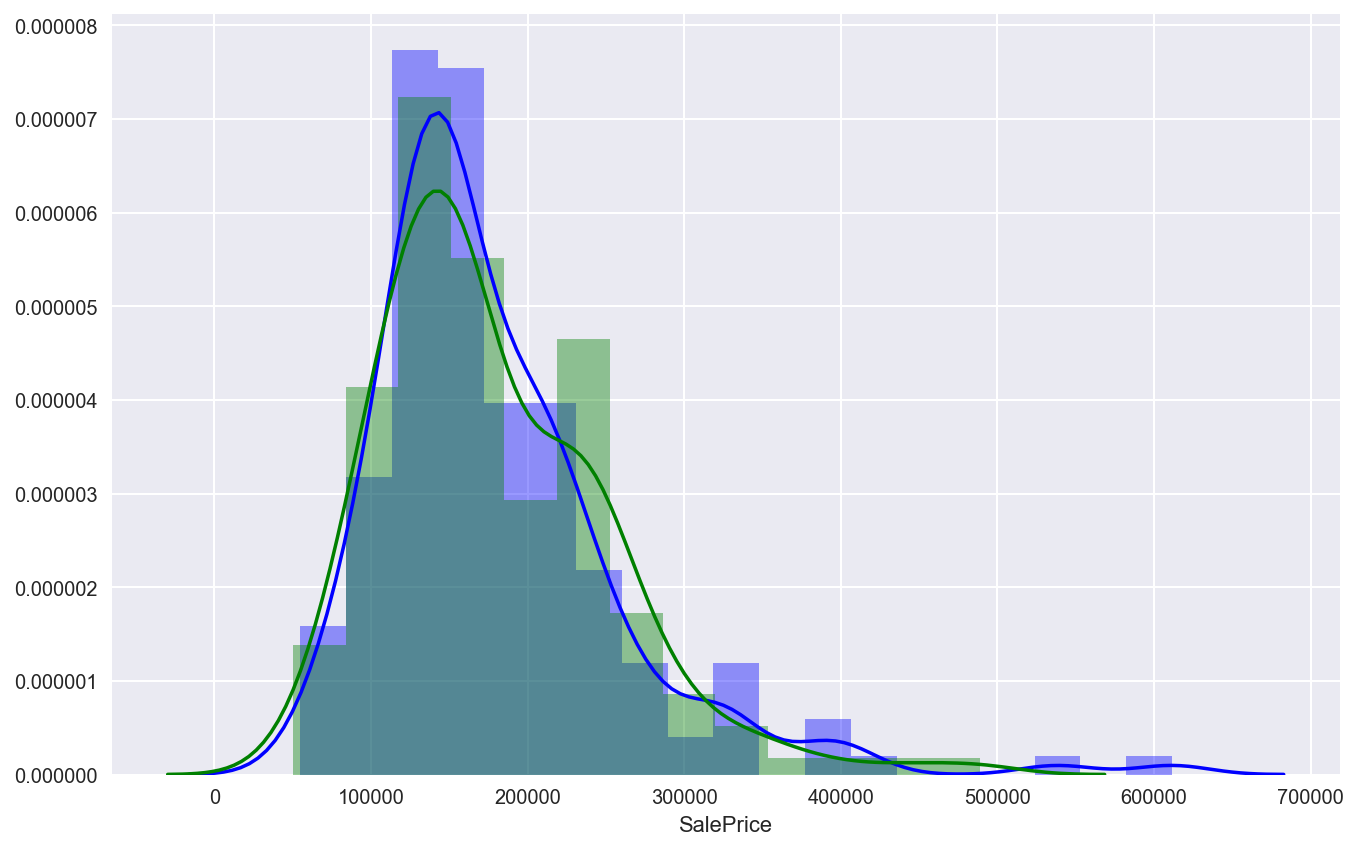

In [51]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()

sns.distplot(y_test, ax=ax, color='b')
sns.distplot(y_pred_ridge_test, ax=ax, color='g')

plt.show()

The graph above shows the true distribution of y against the distribution of yhat. We can see that the model performs fairly well, however it looses accuracy when predicting sales price between 200,000 and 250,000 and also on the tail to the right.

In [52]:
y_res.describe()

count      1446.000000
mean         -9.511687
std       25243.329213
min     -157145.257389
25%      -14108.290223
50%         -39.882951
75%       12768.760473
max      166656.289027
Name: SalePrice, dtype: float64

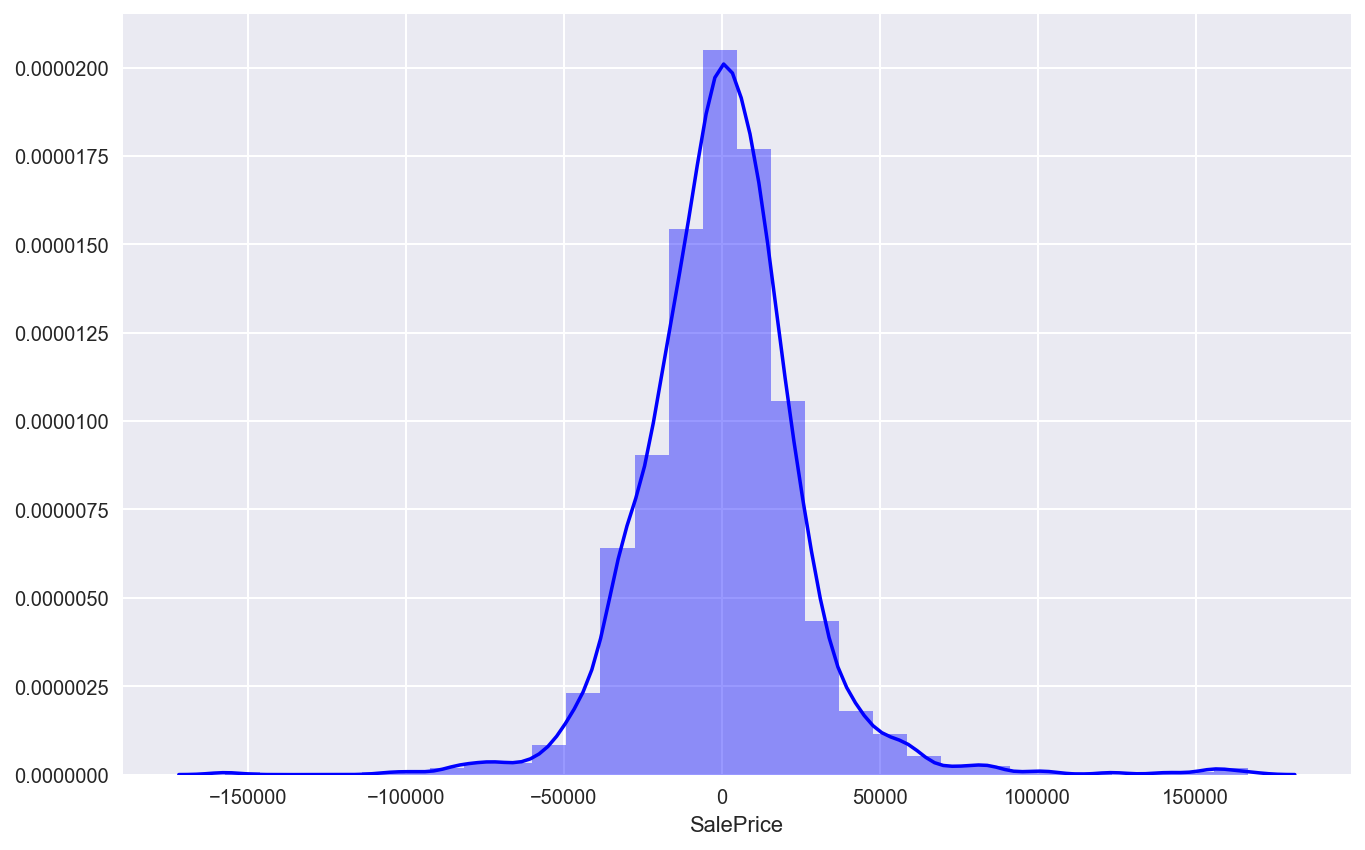

In [53]:
fig = plt.figure(figsize = (11,7))
ax = fig.gca()

sns.distplot(y_res, bins=30, ax=ax, color = 'b')

plt.show()

### 2.1 Preparing the data for linear regression

In [54]:
X_res = house[renovate_feat_list]

In [55]:
cols_to_drop = ['LowQualFinSF', 'Exterior2nd', 'BsmtFinType2', 'BsmtFinSF2', 'MiscVal']
X_res = X_res.drop(cols_to_drop, axis=1)

In [56]:
X_res_d = pd.get_dummies(X_res, columns=['Utilities','RoofStyle','RoofMatl','Exterior1st','MasVnrType','ExterQual','ExterCond', 
                                         'BsmtQual','BsmtCond','BsmtFinType1','Heating','HeatingQC','CentralAir','Electrical', 
                                         'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond', 
                                         'PavedDrive','PoolQC','Fence','MiscFeature'])

### 2.2 Fitting a linear regression model

In [57]:
scaler = StandardScaler()
features_to_standardise = ['OverallQual','OverallCond','BsmtFinSF1','BsmtUnfSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
X_res_d[features_to_standardise] = scaler.fit_transform(X_res_d[features_to_standardise])
Xrs = X_res_d

In [58]:
lm_res = LinearRegression()
model_res = lm_res.fit(Xrs, y_res)
y_pred_res = model_res.predict(Xrs)
score_res = metrics.r2_score(y_res, y_pred_res)
print 'r^2 score: ', score_res 

r^2 score:  0.33185559724


In [59]:
mean_error_res = np.sqrt(metrics.mean_squared_error(y_res, y_pred_res))
print 'Mean error: ', mean_error_res

Mean error:  20626.7866031


In [60]:
y_pred_res_cv = cross_val_predict(model_res, Xrs, y_res, cv=5)
score_res_cv = cross_val_score(model_res, Xrs, y_res, cv=5)
print 'Mean cross validated r^2 score: ', score_res_cv.mean()

Mean cross validated r^2 score:  -3.90582734318e+20


Again we have a low r^2 score after cross validation. It is likely that this is due to the dummy variables again. Regularlisation will hopefully overcome this problem as it did previously. 

### 2.3 Regularisation

##### Ridge

In [61]:
params = {'alpha':np.logspace(1, 2, 200)}

rr_res = Ridge()
estimator_res = GridSearchCV(rr_res, params, cv=5)
estimator_res.fit(Xrs, y_res)
estimator_res.best_estimator_

Ridge(alpha=39.171014908092609, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [62]:
best_res_r = estimator_res.best_estimator_.fit(Xrs, y_res)
y_pred_res_ridge = best_res_r.predict(Xrs)
print 'Model alpha: ', np.round(best_res_r.alpha, 4)
print 'Ridge r^2 score: ', np.round(r2_score(y_res, y_pred_res_ridge), 6)
print 'Ridge mean error: ', np.round(np.sqrt(metrics.mean_squared_error(y_res, y_pred_res_ridge)), 4)

Model alpha:  39.171
Ridge r^2 score:  0.285146
Ridge mean error:  21335.6128


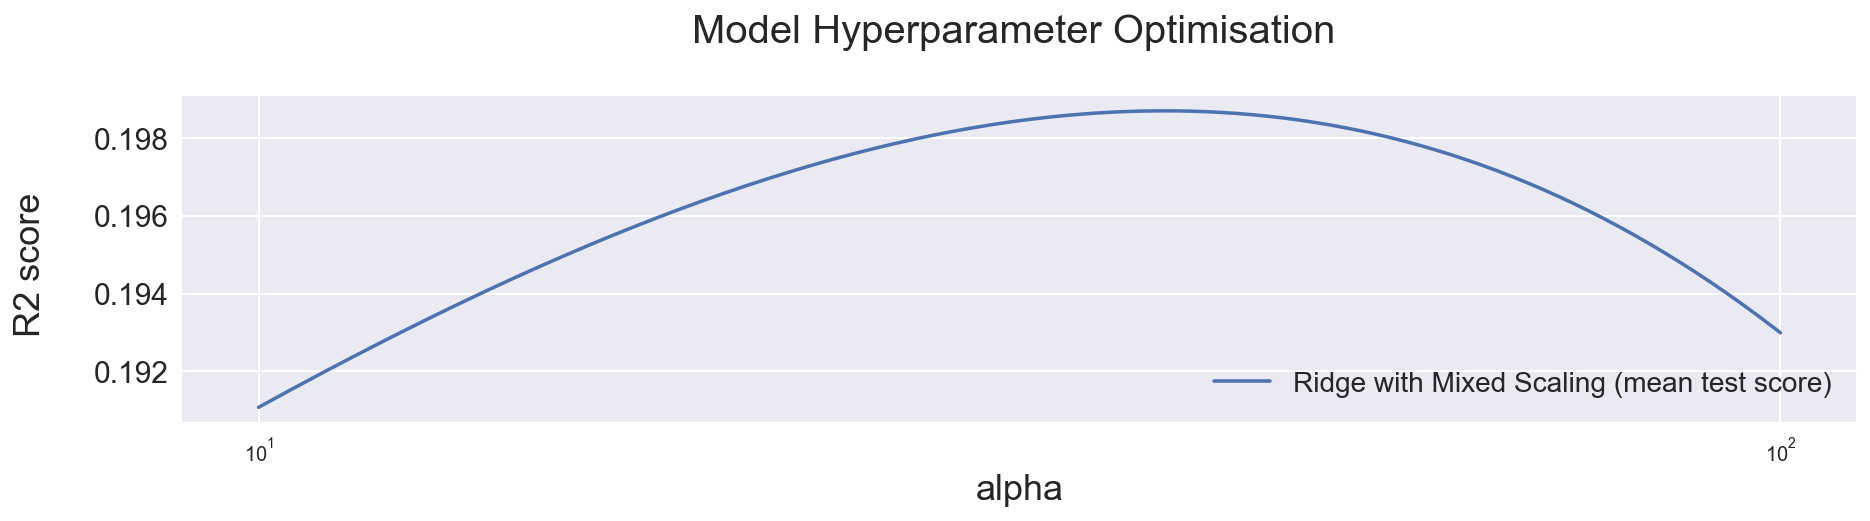

In [63]:
ridge_reg_report = pd.DataFrame(estimator_res.cv_results_)
plot_hp_alpha_opt(ridge_reg_report)

** We can see that the features that we are able to renovate account for around 28 percent of the residuals of the previous model. **



##### Lasso

In [64]:
params_l = {'alpha':np.logspace(0, 3, 200)}
lr = Lasso()
estimator_l = GridSearchCV(lr, params_l, cv=5)
estimator_l.fit(Xrs, y_res)
estimator_l.best_estimator_

Lasso(alpha=224.78058335487253, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [97]:
best_l = estimator_l.best_estimator_.fit(Xrs, y_res)
y_pred_res_lasso = best_l.predict(Xrs)
print 'Model alpha: ', np.round(best_l.alpha, 4)
print 'Lasso r^2 score: ', np.round(r2_score(y_res, y_pred_res_lasso), 6)
print 'Lasso mean error: ', np.round(np.sqrt(metrics.mean_squared_error(y_res, y_pred_res_lasso)), 4)

Model alpha:  224.7806
Lasso r^2 score:  0.256916
Lasso mean error:  21752.8152


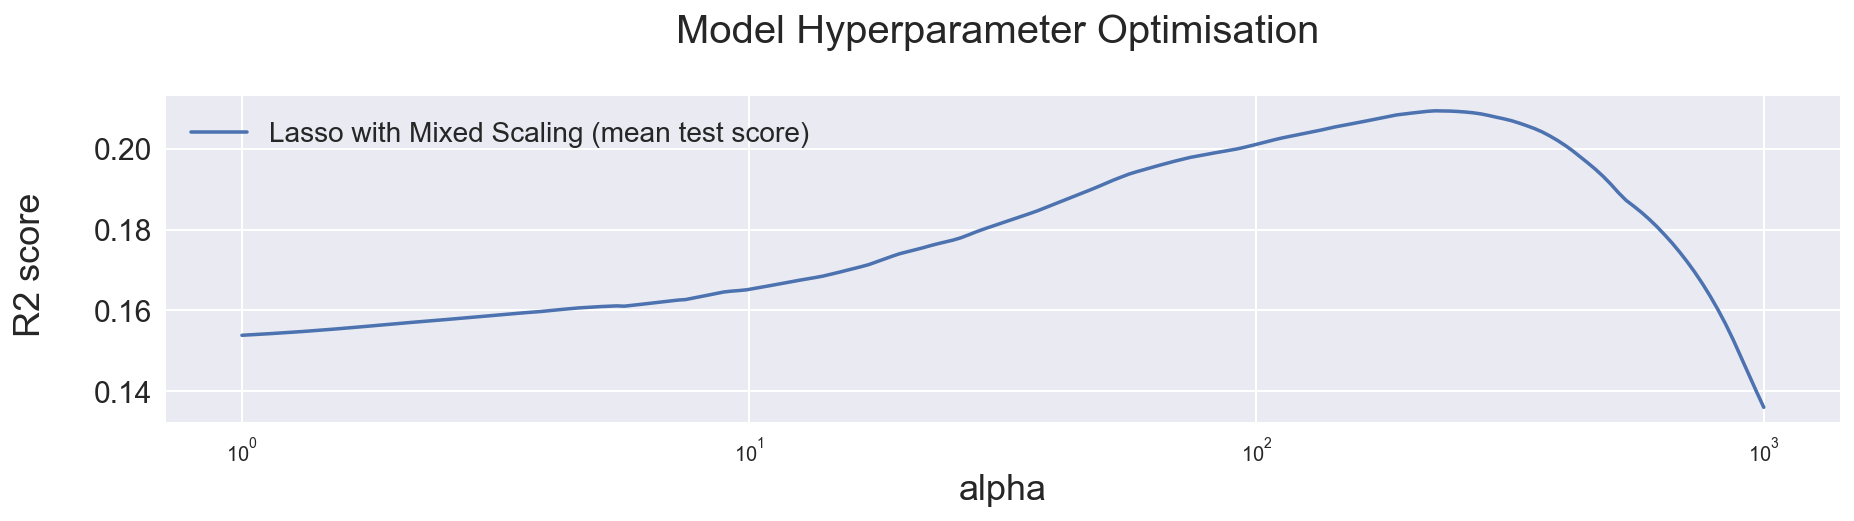

In [66]:
fm_report = pd.DataFrame(estimator_l.cv_results_)
plot_hp_alpha_opt(fm_report, kind='Lasso')

##### Fixed and renovatable features as predictors of price

I am now going to evaluate how accurate my model is at prodecting price when I combine the predicted values from my first model for fixed features and add the predicted residuals from my second model. Although ridge performed slightly better that Lasso, I am going to choose to use the Lasso model, as Lasso reduces coefficients to zero it will help with the interpretability of the model and determining the cost/ benefit of renovations.

In [98]:
preds = y_pred_whole + y_pred_res_lasso

In [99]:
print 'R^2 score of combined model: ', r2_score(preds, y)
print 'Ridge mean error of combined model: ', np.sqrt(metrics.mean_squared_error(y, preds))

R^2 score of combined model:  0.915699034093
Ridge mean error of combined model:  21752.8151619


I can see from the above scores that I have built a strong model, that is a good predictor of sales price. There is a remaining residual of around 0.08 which can not be explained by the linear model I have built. The company can be confident in using this model for estimating sales price, however they should be aware that on average the model is around `$21,753` from the true price of the property.

### Cost / benefit of renovations

<img src="https://s-media-cache-ak0.pinimg.com/originals/c0/d0/14/c0d014b16d1c4993465b379c75a64c43.jpg" style="height: 400px">






In [69]:
beta_res = pd.DataFrame(zip(X_res_d.columns, best_l.coef_))
beta_res.columns = ['variable', 'coef']

In [70]:
xd = X_res_d.describe().T
mean_std = xd[['mean', 'std']]
df_res = pd.merge(beta_res, mean_std, how='outer', right_index = True, left_on= 'variable')

In [71]:
pd.options.display.max_rows = 200
df_res

,variable,coef,mean,std
0,OverallQual,6453.595506,2.627374e-16,1.000346
1,OverallCond,4275.936470,2.106813e-16,1.000346
2,BsmtFinSF1,-0.000000,-5.297745e-18,1.000346
3,BsmtUnfSF,-3486.122749,3.362916e-17,1.000346
4,WoodDeckSF,678.164751,-1.320597e-16,1.000346
5,OpenPorchSF,10.932433,-9.056072e-17,1.000346
6,EnclosedPorch,-42.554050,-1.375878e-16,1.000346
7,3SsnPorch,343.422972,-5.514645e-17,1.000346
8,ScreenPorch,1423.070333,9.958225e-17,1.000346
9,PoolArea,580.439664,-4.753478e-16,1.000346


Taking a look at the coeficients for the different variables above we can start to understand dollar benefit of different renovations. The fist 9 attributes were numerical variables which have been standardised, therefore we can say for each standard deviation the feature increases/decreases by the price will increase/decrease by the coeficient value in dollars. 

For each sd increase in Overall Quality the price of the property increases by `$6,453`, in comparison to each sd increase in Overall Condition which only brings about a `$4,275` increase in sales price. We can see that the quality has a significant impact on sales price therefore the company should seek to focus on high quality renovations. 

We can also see from the data that having an unfinished property can cause significant reductions to sale price of that property. For each sd of unfinished square footage in the basement of a property the price drops by `$3486`. 

A screen porch can increase the property price by `$1423` per sd of square footage. 

For the categorical variables which have been dummified, we have not applied standardisation therefore the coefficient simply represents having that variable or not having it. I have used the lasso regularisation model which has reduced many of these variables to 0 due to high multi-collinearity. 

Categorical variable's that have a significant impact on sale price include: 

 * Having a brick exterior facade increases the sale price by `$9653`
 * Having a wood siding exterior to the property decreases the sale price by `$1107`
 * Excellent quality exterior increases the price by `$8779`
 * Excellent quality basement increases the price by `$3480`
 * Excellent quality kitchen increases the price by `$10,759`
 * Having typical functionality (no deductions) increases the value by `$13,053`
 


<img src="http://clipground.com/images/3-clipart-8.jpg" style="float: left; margin: 25px 25px 0px 0px; height: 60px">



## Part 3:

** Predicting an 'abnormal' sale **

For the final part of this project we will be using the same data set to see if any of the variables can help us predict whether a sale will be abnormal or not. I will be using a logistic regression model to aim to do this.

In this data set an abnormal sale is trade, foreclosure or short sale. 

In [72]:
fixed_feat.SaleCondition_Abnorml.value_counts()

0    1351
1      95
Name: SaleCondition_Abnorml, dtype: int64

We can see that around 95% of our data has a normal sale, therefore it might be difficult to build a model that accurately predicts this due to the class imbalance.

In [73]:
X_ab = Xd.join(X_res_d, how='outer')

In [74]:
X_ab.shape

(1446, 287)

We will need to remove some of the features from the data set which are a product of the abnormal sale as opposed to being a predictor that the sale will not be normal.

These include the other sale condition dummy variables as by default if a sale does not meet any of the other conditions it must be an abnormal sale. The sale type is a product of the condition of sale as opposed to being a fair indicator of an abnormal sale. 

In [75]:
X_ab.drop(['SaleCondition_AdjLand','SaleCondition_Alloca','SaleCondition_Family','SaleCondition_Normal','SaleCondition_Partial',
           'SaleType_COD','SaleType_CWD','SaleType_Con','SaleType_ConLD','SaleType_ConLI','SaleType_ConLw','SaleType_New',
           'SaleType_Oth','SaleType_WD'], axis=1, inplace=True)

I am going to see which variables have the highest and lowest correlation with an abnormal sale and limit the number of variables as I currently have over 200 different attributes. 

In [76]:
X_ab.corr()['SaleCondition_Abnorml'].sort_values().head(30)

YearRemodAdd           -0.125132
GarageCars             -0.101049
Utilities_AllPub       -0.099205
YearBuilt              -0.095664
OverallQual            -0.090078
GarageArea             -0.089478
FireplaceQu_Gd         -0.087539
GarageQual_TA          -0.086292
Foundation_PConc       -0.085628
FullBath               -0.085569
Fireplaces             -0.083719
GarageCond_TA          -0.081625
GarageType_Attchd      -0.079530
MSSubClass_60          -0.071907
BsmtQual_Gd            -0.071105
ExterQual_Gd           -0.070845
Fence_NA               -0.069522
GarageFinish_Fin       -0.064402
Neighborhood_NridgHt   -0.062889
Neighborhood_CollgCr   -0.062751
Electrical_SBrkr       -0.060104
BsmtQual_Ex            -0.058208
HeatingQC_Ex           -0.057813
KitchenQual_Gd         -0.054010
MasVnrType_Stone       -0.052237
HalfBath               -0.052154
Neighborhood_Gilbert   -0.051465
BsmtFinType1_GLQ       -0.050630
ExterQual_Ex           -0.049663
LandContour_HLS        -0.049663
Name: Sale

The majority of features that are negatively correlated to an abnormal sale are features that are linked to a high quality properties which are new-build or recently refurbished with all public utilities. 


In [77]:
X_ab.corr()['SaleCondition_Abnorml'].sort_values().tail(30)

Fence_MnPrv              0.053229
HouseStyle_2.5Fin        0.055485
GarageType_CarPort       0.055485
LotConfig_Corner         0.058687
Electrical_FuseA         0.058776
GarageCond_Po            0.061937
KitchenQual_TA           0.062734
Neighborhood_NAmes       0.063283
BsmtCond_Po              0.065238
Exterior1st_BrkComm      0.065238
Condition2_Artery        0.065238
EnclosedPorch            0.068366
GarageType_Basment       0.070930
Foundation_CBlock        0.072136
HeatingQC_TA             0.075827
MasVnrType_BrkCmn        0.083049
GarageType_NA            0.083641
GarageCond_NA            0.083641
GarageFinish_NA          0.083641
GarageQual_NA            0.083641
ExterQual_TA             0.085975
FireplaceQu_NA           0.090924
BsmtQual_TA              0.095657
PoolQC_Ex                0.099205
Electrical_Mix           0.099205
Functional_Sev           0.099205
Utilities_NoSeWa         0.099205
MSZoning_RH              0.105370
Exterior1st_Stone        0.140345
SaleCondition_

Attributes that are possitively correlated to an abnormal sale include buildings with a stone exterior, high dentisy residential areas, properties lacking untilities and properties with below average quality and condition variables. 

We can see that excellent pool quality is possitively correlated with an abnormal sale, let's have a closer look at this:

In [78]:
X_ab.PoolQC_Ex.value_counts()

0    1445
1       1
Name: PoolQC_Ex, dtype: int64

In [79]:
X_ab[X_ab.PoolQC_Ex == 1]

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
197,4.991595,1.513325,-1.783026,0.243115,-0.576394,0.745415,0.54389,2.352481,3.231627,1.108695,...,1,0,0,0,0,0,1,0,0,0


Looking closely at this instance we can see that there is only one property with excellent pool quality in the whole data set. This happens to be a abnormal sale so it is skewing the data.

In [80]:
y_ab = X_ab.SaleCondition_Abnorml

In [81]:
X_ab.drop('SaleCondition_Abnorml', axis=1, inplace=True)

Firstly I will check what our baseline accuracy is:

In [82]:
print "Baseline Accuracy", 1 - y_ab.mean()

Baseline Accuracy 0.934301521438


In [83]:
scaler = StandardScaler()
standard = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
            'GarageCars','GarageArea','YrSold','OverallQual','OverallCond','BsmtFinSF1','BsmtUnfSF','WoodDeckSF',
            'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
X_ab[standard] = scaler.fit_transform(X_ab[standard])
X_ab_s = X_ab

In [84]:
from sklearn.linear_model import LogisticRegressionCV
mod_cv = LogisticRegressionCV(cv=5)
mod_cv.fit(X_ab_s, y_ab) 
print "Model accuracy cross validated:", mod_cv.score(X_ab_s,y_ab)

Model accuracy cross validated: 0.934301521438


As we can see from above the cross validated score from the logistic regression model is exactly the same as the baseline accuracy. This is due to the fact that we have a significant class imbalance in the target variable. 

Fist of all I am going to limit the attributes to the ones with the highest and lowest correlation with abnormal sale.

In [85]:
X_ab_s = pd.DataFrame(X_ab_s, columns=X_ab.columns)

In [86]:
X_ab.shape

(1446, 272)

In [87]:
X_ab_s.shape

(1446, 272)

In [88]:
ab_sale = X_ab_s[['YearRemodAdd', 'GarageCars','Utilities_AllPub','YearBuilt','OverallQual','GarageArea', 'FireplaceQu_Gd',
           'GarageQual_TA','Foundation_PConc','FullBath','Fireplaces','GarageCond_TA','GarageType_Attchd',   
           'MSSubClass_60','BsmtQual_Gd','ExterQual_Gd','Fence_NA','GarageFinish_Fin','Neighborhood_NridgHt','Neighborhood_CollgCr',
           'Electrical_SBrkr','BsmtQual_Ex','HeatingQC_Ex','KitchenQual_Gd','HalfBath','MasVnrType_Stone','Neighborhood_Gilbert',
           'BsmtFinType1_GLQ','GarageType_CarPort','LotConfig_Corner','Electrical_FuseA','GarageCond_Po','KitchenQual_TA',     
           'Neighborhood_NAmes','Condition2_Artery','BsmtCond_Po','Exterior1st_BrkComm','EnclosedPorch','GarageType_Basment',  
           'Foundation_CBlock','HeatingQC_TA','MasVnrType_BrkCmn','GarageCond_NA','GarageType_NA','GarageFinish_NA',     
           'GarageQual_NA','ExterQual_TA','FireplaceQu_NA','BsmtQual_TA','Utilities_NoSeWa','Functional_Sev','Electrical_Mix',    
           'MSZoning_RH','Exterior1st_Stone']]           

In [89]:
mod_cv = LogisticRegressionCV(cv=5, Cs =15)
mod_cv.fit(ab_sale, y_ab)
print "Model accuracy cross validated:", mod_cv.score(ab_sale,y_ab)

Model accuracy cross validated: 0.938450899032


In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [91]:
predict_ab = mod_cv.predict(ab_sale)

print classification_report(y_ab, predict_ab)

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1351
          1       0.80      0.08      0.15        95

avg / total       0.93      0.94      0.91      1446



In [92]:
cnf_matrix = confusion_matrix(y_ab, predict_ab)

In [93]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

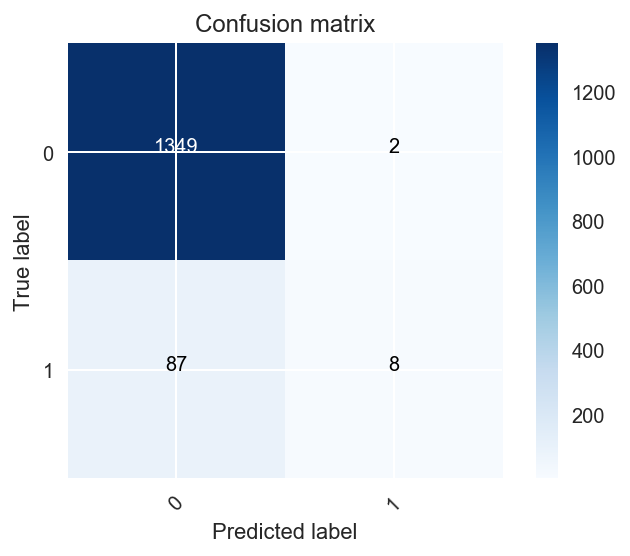

In [94]:
plot_confusion_matrix(cnf_matrix, classes=mod_cv.classes_)

Reducing the number of attributes to the ones with the stongest correlation with the sale being abnormal has improved the model slightly, however it is only marginally above the beseline.

We can see from the graph above that the model is returning a false possitive result (predicting normal when the true value is abnormal) in 87 cases. With this example we would want to reduce this outcome as much as possible. One way I could try to overcome this would be to do a random over sampling of the minority class, increasing the representaion of the minority class within the data set. 

